<a href="https://colab.research.google.com/github/cusniwtt/Thai-Traffic-Signs-Recognition/blob/main/Thai_Traffic_Signs_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Thai traffic signs recognition**
---
![link text](https://img.shields.io/static/v1?label=STATUS&message=DEVELOPING&color=<COLOR>) </br>
**Contributors** </br>
* Wayu Ragwongsiri
* Kanchayapond
* Natchanapat
* Nichapat
* Thanitapach

Repository: [Thai Traffic Signs Recognition](https://github.com/cusniwtt/Thai-Traffic-Signs-Recognition)

> This notebook focus to recognize Thai traiffic signs images that contain 10 classes and 40-50 images for each classes. In 8 May 2022, We don't have databases or dataset of Thai traffic signs. So, We create dataset by ourselves. Dataset that we use are here in repository. You can clone it and follow this notebook.



Create directory to contain result folders

In [1]:
!mkdir model

In [2]:
!mkdir weight_improvement

Import Library

In [3]:
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import np_utils
from keras.layers.convolutional import  MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import os, fnmatch
import cv2
from tqdm.notebook import tqdm
from time import sleep
from numpy.random import seed
from pathlib import Path
from PIL import Image
import seaborn as sns
%matplotlib inline

Define function to demonstrate graph

In [4]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
# **** UPDATE ****
# Change from lastes to Highest Accuracy
def show_result(history): 
    temph = history.history
    temp_loss = temph['loss']
    temp_acc = temph['acc']
    temp_vloss = temph['val_acc']
    temp_vacc = temph['val_acc']

    max_valacc = max(temp_vacc)
    max_index = temp_vacc.index(max_valacc)
    max_index

    # Print the result from the Highest val_acc epoch
    print('Highest validation accuracy in Epoch: %s'%str(max_index+1))
    print('Train accuracy: %s'%temp_acc[max_index])
    print('Validation accuracy: %s'%temp_vacc[max_index])

    print('--------------------------------------------------')
    
    # Print the result from the last epoch
    print('Last train Epoch')
    print('Train accuracy: %s'%history.history['acc'][-1])
    print('Validation accuracy: %s'%history.history['val_acc'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate(features,labels,verbose=False)
    
    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    labels = labels.argmax(axis=1)
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))
    
    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')
    
    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))
            
# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
        
def deprocess_image(img):
    
    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    
    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)
    
    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')
    
    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]
    
    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)
    
    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])
    
    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)
            
            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)  

Define function for utility

In [5]:
# change sub directory in list
def dirToList(dir_path):
  
  #get path create list
  pth = os.listdir(path=dir_path)
  lst_dir = []

  for s in pth:
    temp = str(dir_path + '/' + s + '/')
    lst_dir.append(temp)
  
  #remove .csv
  for i in tqdm(range(len(lst_dir))):
    if lst_dir[i-1][len(lst_dir[i-1])-4:] == 'csv/':
      lst_dir.pop(i-1)
    if lst_dir[i-1][len(lst_dir[i-1])-4:] == 'md/':
      lst_dir.pop(i-1)

  return lst_dir

# change other jpg to png
def JPGtoPNG(dir_path):
  a = dirToList(dir_path)

  # Get path that contain only .jpg .JPG .PNG
  lst_jpg = []
  for i in range(len(a)):
    fls_nm = fnmatch.filter(os.listdir(a[i]), "*.PNG")

    #check that path only contain .jpg files (is not 0)
    for j in range(len(fls_nm)):
      lst_fls = [a[i],fls_nm[j]]
      if len(lst_fls[1]) is not 0:
        lst_jpg.append(lst_fls)

  #convert from jpg to png
  round = 1
  for k in tqdm(range(len(lst_jpg))):
    format = Image.open(r''+lst_jpg[k][0]+lst_jpg[k][1])
    format.save(r''+lst_jpg[k][0]+lst_jpg[k][1][:-3]+'png')
    
    #Remove other images format
    os.remove(lst_jpg[k][0]+lst_jpg[k][1])
    round = round + 1

  print('Successfully ' + str(k) + ' images')

# map path to name
def mapName(lab_list, lab_dict):
  temp = []
  for i in tqdm(range(len(lab_list))):
    key_label = lab_dict[lab_list[i]]
    temp.append(key_label)
  return temp

## Import Dataset
---

#### Get Metadata and move dataset into local computer

In [6]:
 !git clone https://github.com/cusniwtt/Thai-Traffic-Signs-Recognition.git

Cloning into 'Thai-Traffic-Signs-Recognition'...
remote: Enumerating objects: 519, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 519 (delta 6), reused 0 (delta 0), pack-reused 507
Receiving objects: 100% (519/519), 62.49 MiB | 38.41 MiB/s, done.
Resolving deltas: 100% (16/16), done.


Convert file from **.PNG** ---> **.png**

In [7]:
JPGtoPNG('/content/Thai-Traffic-Signs-Recognition/Dataset')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Successfully 3 images



Now we will get metadata from csv

In [8]:
header_list = ["id", "Description"]
md = pd.read_csv('/content/Thai-Traffic-Signs-Recognition/TTS metadata.csv', names=header_list)
md

,id,Description
0,cr,Crossroad
1,cw,Crosswalk
2,le,Left Always pass
3,pr,Predestrain
4,ro,Roundabout
5,sc,School
6,30,Speed Limit 30
7,80,Speed Limit 80
8,tl,Traffic signal ahead
9,ut,U turn


### **Create directory dataframe**
---



#### If dataset not split, Use this method

Create index dict from dataframe

In [9]:
label_dict = dict(zip(md['id'], md['Description']))
label_dict

{'30': 'Speed Limit 30',
 '80': 'Speed Limit 80',
 'cr': 'Crossroad',
 'cw': 'Crosswalk',
 'le': 'Left Always pass',
 'pr': 'Predestrain',
 'ro': 'Roundabout',
 'sc': 'School',
 'tl': 'Traffic signal ahead',
 'ut': 'U turn'}

Get file directory

In [10]:
sub_dir = dirToList('/content/Thai-Traffic-Signs-Recognition/Dataset')
sub_dir

  0%|          | 0/10 [00:00<?, ?it/s]

['/content/Thai-Traffic-Signs-Recognition/Dataset/Predestrain/',
 '/content/Thai-Traffic-Signs-Recognition/Dataset/U turn/',
 '/content/Thai-Traffic-Signs-Recognition/Dataset/Crossroad/',
 '/content/Thai-Traffic-Signs-Recognition/Dataset/Roundabout/',
 '/content/Thai-Traffic-Signs-Recognition/Dataset/Traffic signal ahead/',
 '/content/Thai-Traffic-Signs-Recognition/Dataset/Crosswalk/',
 '/content/Thai-Traffic-Signs-Recognition/Dataset/School/',
 '/content/Thai-Traffic-Signs-Recognition/Dataset/Speed Limit 30/',
 '/content/Thai-Traffic-Signs-Recognition/Dataset/Speed Limit 80/',
 '/content/Thai-Traffic-Signs-Recognition/Dataset/Left always pass/']

In [11]:
sub_dir_Path = Path('../content/Thai-Traffic-Signs-Recognition/Dataset')
all_filepaths = list(sub_dir_Path.glob(r'**/*.png'))
all_filepaths[:10]

[PosixPath('../content/Thai-Traffic-Signs-Recognition/Dataset/Predestrain/pr_043.png'),
 PosixPath('../content/Thai-Traffic-Signs-Recognition/Dataset/Predestrain/pr_041.png'),
 PosixPath('../content/Thai-Traffic-Signs-Recognition/Dataset/Predestrain/pr_036.png'),
 PosixPath('../content/Thai-Traffic-Signs-Recognition/Dataset/Predestrain/pr_012.png'),
 PosixPath('../content/Thai-Traffic-Signs-Recognition/Dataset/Predestrain/pr_011.png'),
 PosixPath('../content/Thai-Traffic-Signs-Recognition/Dataset/Predestrain/pr_040.png'),
 PosixPath('../content/Thai-Traffic-Signs-Recognition/Dataset/Predestrain/pr_032.png'),
 PosixPath('../content/Thai-Traffic-Signs-Recognition/Dataset/Predestrain/pr_003.png'),
 PosixPath('../content/Thai-Traffic-Signs-Recognition/Dataset/Predestrain/pr_029.png'),
 PosixPath('../content/Thai-Traffic-Signs-Recognition/Dataset/Predestrain/pr_048.png')]

Convert file name into index

In [12]:
all_path = []
all_index = []
for i in tqdm(range(len(sub_dir))):
  temp = fnmatch.filter(os.listdir(sub_dir[i]), "*.png")
  all_path.append(temp)
all_path_con =[item for sublist in all_path for item in sublist]
for i in tqdm(range(len(all_path_con))):
  index = all_path_con[i][:2]
  all_index.append(index)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

Map index into description

In [13]:
all_path_map = mapName(all_index, label_dict)
all_path_map[:10]

  0%|          | 0/462 [00:00<?, ?it/s]

['Predestrain',
 'Predestrain',
 'Predestrain',
 'Predestrain',
 'Predestrain',
 'Predestrain',
 'Predestrain',
 'Predestrain',
 'Predestrain',
 'Predestrain']

Convert file directory and description to single dataframe

In [14]:
all_filepaths_df = pd.Series(all_filepaths , name = 'filepath').astype(str)
all_path_map_df = pd.Series(all_path_map, name = 'label')

all_df = pd.concat([all_filepaths_df, all_path_map_df], axis = 1)
all_df.shape

(462, 2)

In [15]:
all_df.head()

,filepath,label
0,../content/Thai-Traffic-Signs-Recognition/Data...,Predestrain
1,../content/Thai-Traffic-Signs-Recognition/Data...,Predestrain
2,../content/Thai-Traffic-Signs-Recognition/Data...,Predestrain
3,../content/Thai-Traffic-Signs-Recognition/Data...,Predestrain
4,../content/Thai-Traffic-Signs-Recognition/Data...,Predestrain


split to multiple dataframe for train-test split

In [16]:
df_30 = all_df.loc[all_df['label'] == label_dict['30']]
df_80 = all_df.loc[all_df['label'] == label_dict['80']]
cr_df = all_df.loc[all_df['label'] == label_dict['cr']]
cw_df = all_df.loc[all_df['label'] == label_dict['cw']]
le_df = all_df.loc[all_df['label'] == label_dict['le']]
pr_df = all_df.loc[all_df['label'] == label_dict['pr']]
ro_df = all_df.loc[all_df['label'] == label_dict['ro']]
sc_df = all_df.loc[all_df['label'] == label_dict['sc']]
tl_df = all_df.loc[all_df['label'] == label_dict['tl']]
ut_df = all_df.loc[all_df['label'] == label_dict['ut']]

Train test split

In [17]:
d3_Tr, d3_te = train_test_split(df_30, test_size = .1)
d8_Tr, d8_te = train_test_split(df_80, test_size = .1)
cr_Tr, cr_te = train_test_split(cr_df, test_size = .1)
cw_Tr, cw_te = train_test_split(cw_df, test_size = .1)
le_Tr, le_te = train_test_split(le_df, test_size = .1)

In [18]:
pr_Tr, pr_te = train_test_split(pr_df, test_size = .1)
ro_Tr, ro_te = train_test_split(ro_df, test_size = .1)
sc_Tr, sc_te = train_test_split(sc_df, test_size = .1)
tl_Tr, tl_te = train_test_split(tl_df, test_size = .1)
ut_Tr, ut_te = train_test_split(ut_df, test_size = .1)

Train validation split

In [19]:
d3_tr, d3_va = train_test_split(d3_Tr, test_size = .05)
d8_tr, d8_va = train_test_split(d8_Tr, test_size = .05)
cr_tr, cr_va = train_test_split(cr_Tr, test_size = .05)
cw_tr, cw_va = train_test_split(cw_Tr, test_size = .05)
le_tr, le_va = train_test_split(le_Tr, test_size = .05)

In [20]:
pr_tr, pr_va = train_test_split(pr_Tr, test_size = .05)
ro_tr, ro_va = train_test_split(ro_Tr, test_size = .05)
sc_tr, sc_va = train_test_split(sc_Tr, test_size = .05)
tl_tr, tl_va = train_test_split(tl_Tr, test_size = .05)
ut_tr, ut_va = train_test_split(ut_Tr, test_size = .05)

Merge to single dataset

In [21]:
df_train = pd.concat([d3_tr, d8_tr, cr_tr, cw_tr, le_tr, pr_tr, ro_tr, sc_tr, tl_tr, ut_tr])
print(df_train.shape)
df_train.head()

(390, 2)


,filepath,label
342,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 30
362,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 30
368,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 30
338,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 30
374,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 30


In [22]:
df_val = pd.concat([d3_va, d8_va, cr_va, cw_va, le_va, pr_va, ro_va, sc_va, tl_va, ut_va])
print(df_val.shape)
df_val.head()

(25, 2)


,filepath,label
350,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 30
366,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 30
403,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 80
394,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 80
139,../content/Thai-Traffic-Signs-Recognition/Data...,Crossroad


In [23]:
df_test = pd.concat([d3_te, d8_te, cr_te, cw_te, le_te, pr_te, ro_te, sc_te, tl_te, ut_te])
print(df_test.shape)
df_test.head()

(47, 2)


,filepath,label
354,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 30
339,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 30
349,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 30
351,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 30
404,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 80


# **Convolutional Neural Network**

## Load Dataset & Preprocessing

Create image generator

In [24]:
#create preset of image generator
train_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range = [0.4,1.5],
    zoom_range = 0.3,
    fill_mode = 'reflect'
)

validate_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)


test_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

Parameter setup

In [25]:
X_COL = 'filepath'
Y_COL = 'label'
MODE = 'rgb'
BATCH_SIZE = 16

In [26]:
#load data by flow_from_dataframe
train_ds = train_generator.flow_from_dataframe(
    dataframe = df_train,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = (224, 224),
    color_mode = MODE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

val_ds = validate_generator.flow_from_dataframe(
    dataframe = df_val,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = (224, 224),
    color_mode = MODE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

test_ds = test_generator.flow_from_dataframe(
    dataframe = df_test,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = (224, 224),
    color_mode = MODE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

Found 390 validated image filenames belonging to 10 classes.
Found 25 validated image filenames belonging to 10 classes.
Found 47 validated image filenames belonging to 10 classes.


## Build a convolutional neural network

### Transfer Learning

In [27]:
from tensorflow.keras.applications import InceptionResNetV2
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

In [28]:
def def_model():
  model = InceptionResNetV2(
      include_top=False, 
      input_shape=(224, 224, 3)
  )
  for layer in model.layers:
  		layer.trainable = False
  flat1 = Flatten()(model.layers[-1].output)
  full_conn = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  output = Dense(10, activation='sigmoid')(full_conn)
	# define new model
  model = Model(inputs=model.inputs, outputs=output)
	# compile model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
  model.save('/content/model/InceptionResNetV2.h5')
  model.summary()
  return model

In [29]:
irnv2 = def_model()

219070464/219055592 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                

In [30]:
save_path = '/content/weight_improvement/irnv2_x224_{epoch:02d}_{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(save_path, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
callbacks_list = [checkpoint]

history3 = irnv2.fit(
    train_ds, 
    batch_size=16,
    epochs=100,
    validation_data=(val_ds),
    callbacks = callbacks_list
)
irnv2.save('/content/model/InceptionResNetV2_x224_itr100.h5')

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 33.6436 - acc: 0.0641
Epoch 1: val_acc improved from -inf to 0.20000, saving model to /content/weight_improvement/irnv2_x224_01_0.20.hdf5
25/25 [==============================] - 32s 501ms/step - loss: 33.6436 - acc: 0.0641 - val_loss: 4.4112 - val_acc: 0.2000
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 3.4067 - acc: 0.1205
Epoch 2: val_acc improved from 0.20000 to 0.28000, saving model to /content/weight_improvement/irnv2_x224_02_0.28.hdf5
25/25 [==============================] - 9s 341ms/step - loss: 3.4067 - acc: 0.1205 - val_loss: 1.7620 - val_acc: 0.2800
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 1.9338 - acc: 0.2718
Epoch 3: val_acc improved from 0.28000 to 0.32000, saving model to /content/weight_improvement/irnv2_x224_03_0.32.hdf5
25/25 [==============================] - 9s 347ms/step - loss: 1.9338 - acc: 0.2718 - val_loss: 1.8775 - val_acc: 0.3200
Epoch 4/10

Highest validation accuracy in Epoch: 53
Train accuracy: 0.8051282167434692
Validation accuracy: 0.9200000166893005
--------------------------------------------------
Last train Epoch
Train accuracy: 0.8846153616905212
Validation accuracy: 0.9200000166893005


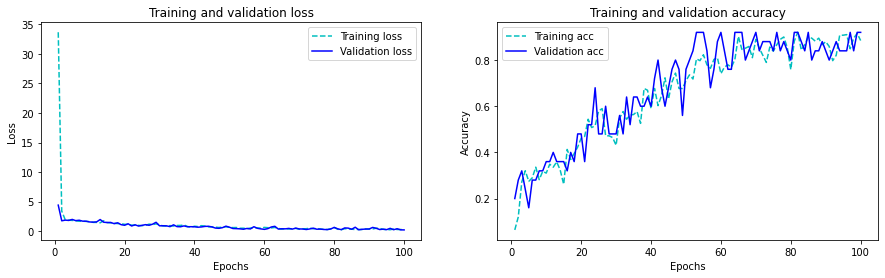

In [31]:
show_result(history3)

## Evaluation

Last epoch test

In [32]:
result = irnv2.evaluate(test_ds, verbose=0)

print("Test loss: {:.5f}".format(result[0]))
print("Test accuracy: {:.2f}".format(result[1]))

Test loss: 0.24621
Test accuracy: 0.94


Highest validation accuracy epoch test

In [34]:
model = load_model('/content/weight_improvement/irnv2_x224_53_0.92.hdf5')

result = model.evaluate(test_ds, verbose=0)

print("Test loss: {:.5f}".format(result[0]))
print("Test accuracy: {:.2f}".format(result[1]))

Test loss: 0.44082
Test accuracy: 0.83


# **Support Vector Machine**

Import library

In [35]:
from skimage.filters import sobel
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from PIL import Image

import random

## Preprocessing
> For this session, We use same method to create dataset. First, Images will geneate by keras to generate by parameter that  we set. Next, We convert images dataset to array for computing with Support Vector Machine and Random Forest. So, we can use data augmentation method before get dataset into feature extraction. </br>

Load image in batch size = 1 for generate array from images by each image

In [36]:
# Split df to each classes
df_30 = all_df.loc[all_df['label'] == label_dict['30']]
df_80 = all_df.loc[all_df['label'] == label_dict['80']]
cr_df = all_df.loc[all_df['label'] == label_dict['cr']]
cw_df = all_df.loc[all_df['label'] == label_dict['cw']]
le_df = all_df.loc[all_df['label'] == label_dict['le']]
pr_df = all_df.loc[all_df['label'] == label_dict['pr']]
ro_df = all_df.loc[all_df['label'] == label_dict['ro']]
sc_df = all_df.loc[all_df['label'] == label_dict['sc']]
tl_df = all_df.loc[all_df['label'] == label_dict['tl']]
ut_df = all_df.loc[all_df['label'] == label_dict['ut']]

# Group 1
d3_tr, d3_te = train_test_split(df_30, test_size = .1)
d8_tr, d8_te = train_test_split(df_80, test_size = .1)
cr_tr, cr_te = train_test_split(cr_df, test_size = .1)
cw_tr, cw_te = train_test_split(cw_df, test_size = .1)
le_tr, le_te = train_test_split(le_df, test_size = .1)
pr_tr, pr_te = train_test_split(pr_df, test_size = .1)
ro_tr, ro_te = train_test_split(ro_df, test_size = .1)
sc_tr, sc_te = train_test_split(sc_df, test_size = .1)
tl_tr, tl_te = train_test_split(tl_df, test_size = .1)
ut_tr, ut_te = train_test_split(ut_df, test_size = .1)

# train test split
df_train = pd.concat([d3_tr, d8_tr, cr_tr, cw_tr, le_tr, pr_tr, ro_tr, sc_tr, tl_tr, ut_tr])
print(df_train.shape)

df_test = pd.concat([d3_te, d8_te, cr_te, cw_te, le_te, pr_te, ro_te, sc_te, tl_te, ut_te])
print(df_test.shape)

(415, 2)
(47, 2)


In [37]:
#create preset of image generator
train_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range = [0.4,1.5],
    zoom_range = 0.3,
    fill_mode = 'reflect'
)

validate_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)


test_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

In [38]:
X_COL = 'filepath'
Y_COL = 'label'
MODE = 'rgb'
BATCH_SIZE = 1

#load data by flow_from_dataframe
train_ds = train_generator.flow_from_dataframe(
    dataframe = df_train,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = (224, 224),
    color_mode = MODE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

test_ds = test_generator.flow_from_dataframe(
    dataframe = df_test,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = (224, 224),
    color_mode = MODE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

Found 415 validated image filenames belonging to 10 classes.
Found 47 validated image filenames belonging to 10 classes.


Convert image to array

In [39]:
train_list = []
batch_index_train = 0

while batch_index_train <= train_ds.batch_index:
    data = train_ds.next()
    train_list.append(data[0])
    batch_index_train = batch_index_train + 1

# now, data_array is the numeric data of whole images
train_array = np.asarray(train_list)

train_array.shape

(415, 1, 224, 224, 3)

In [40]:
test_list = []
batch_index_test = 0

while batch_index_test <= test_ds.batch_index:
    data = test_ds.next()
    test_list.append(data[0])
    batch_index_test = batch_index_test + 1

# now, data_array is the numeric data of whole images
test_array = np.asarray(test_list)

print(test_array.shape)

(47, 1, 224, 224, 3)


Reduce dimension of batch size

In [41]:
train_array = np.squeeze(train_array, axis=1)
train_array.shape

(415, 224, 224, 3)

In [42]:
test_array = np.squeeze(test_array, axis=1)
test_array.shape

(47, 224, 224, 3)

In [43]:
print(df_train.shape)
df_train.head()

(415, 2)


,filepath,label
366,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 30
369,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 30
344,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 30
357,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 30
350,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 30


In [44]:
print(df_test.shape)
df_test.head()

(47, 2)


,filepath,label
341,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 30
361,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 30
360,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 30
372,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 30
416,../content/Thai-Traffic-Signs-Recognition/Data...,Speed Limit 80


Encode labels from index to integers

In [45]:
le = preprocessing.LabelEncoder()
le.fit(df_train['label'])
y_train = le.transform(df_train['label'])
le.fit(df_test['label'])
y_test = le.transform(df_test['label'])

In [46]:
y_train.shape

(415,)

In [47]:
y_test.shape

(47,)

In [48]:
encode_dict = {  '0': 'Crossroad',
                 '1': 'Crosswalk',
                 '2': 'Left Always pass',
                 '3': 'Predestrain',
                 '4': 'Roundabout',
                 '5': 'School',
                 '6': 'Speed Limit 30',
                 '7': 'Speed Limit 80',
                 '8': 'Traffic signal ahead',
                 '9': 'U turn'
}

## Feature Extraction

In [70]:
def feature_extractor(dataset):
    x_train = dataset
    image_dataset = pd.DataFrame()

    #iterate through each file 
    for image in tqdm(range(x_train.shape[0])):  
        
        #Temporary data frame to capture information for each loop.
        df = pd.DataFrame()
        #Reset dataframe to blank after each loop.
        
        input_img = x_train[image, :,:,:]
        img = input_img

        #START ADDING DATA TO THE DATAFRAME
        #Add feature extractors, e.g. edge detection, smoothing, etc. 
            
          # FEATURE 1 - Pixel values
         
        #Add pixel values to the data frame
        pixel_values = img.reshape(-1)
        df['Pixel_Value'] = pixel_values   #Pixel value itself as a feature
        
          # FEATURE 2 - Bunch of Gabor filter responses
        
        #Generate Gabor features
        #To count numbers up in order to give Gabor features a lable in the data frame
        num = 1  
        kernels = []

        #Define number of thetas
        for theta in range(2):
            theta = theta / 4. * np.pi

            #Sigma with 1 and 3
            for sigma in (1, 3):
                lamda = np.pi/4
                gamma = 0.5
                #Label Gabor columns as Gabor1, Gabor2, etc.
                gabor_label = 'Gabor ' + str(num)
                ksize=9
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)
                #Now filter the image and add values to a new column 
                fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                
                num += 1  #Increment for gabor column label
                
         
        # FEATURE 3 Sobel
        edge_sobel = sobel(img)
        edge_sobel1 = edge_sobel.reshape(-1)
        df['Sobel'] = edge_sobel1
       
        #Add more filters as needed
        
        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)
        
    return image_dataset

In [71]:
#Extract features from training images
image_features = feature_extractor(train_array)

  0%|          | 0/415 [00:00<?, ?it/s]

In [72]:
image_features

,Pixel_Value,Gabor 1,Gabor 2,Gabor 3,Gabor 4,Sobel
0,0.062745,0,0,0,0,0.016736
1,0.031373,0,0,0,0,0.005805
2,0.050980,0,0,0,0,0.010769
3,0.062745,0,0,1,0,0.016917
4,0.031373,0,0,0,0,0.006101
...,...,...,...,...,...,...
150523,0.823529,2,3,7,7,0.101411
150524,0.549020,2,2,5,5,0.170440
150525,0.749020,2,3,6,6,0.089104
150526,0.894118,3,3,7,8,0.087336


In [73]:
test_features = feature_extractor(test_array)

  0%|          | 0/47 [00:00<?, ?it/s]

In [74]:
test_features

,Pixel_Value,Gabor 1,Gabor 2,Gabor 3,Gabor 4,Sobel
0,0.756863,2,0,6,6,0.011321
1,0.776471,2,0,6,7,0.020377
2,0.792157,2,1,7,7,0.009056
3,0.756863,2,2,6,6,0.011321
4,0.776471,2,2,6,6,0.020377
...,...,...,...,...,...,...
150523,0.592157,2,2,5,5,0.115825
150524,0.400000,1,1,3,4,0.111311
150525,0.600000,2,2,5,5,0.004528
150526,0.592157,2,2,5,5,0.115470


Reshape to a vector for RF and SVM

In [75]:
n_features = image_features.shape[1]
image_features = np.expand_dims(image_features, axis=0)
x_train = np.reshape(image_features, (train_array.shape[0], -1))  #Reshape to #images, features

In [76]:
x_train.shape

(415, 903168)

In [77]:
#Reshape from test data, just like training data
test_features = np.expand_dims(test_features, axis=0)
x_test = np.reshape(test_features, (test_array.shape[0], -1))

In [78]:
x_test.shape

(47, 903168)

## Modeling

In [79]:
from sklearn import svm
SVM_model = svm.SVC(decision_function_shape='ovo')  #For multiclass classification
SVM_model.fit(x_train, y_train)

SVC(decision_function_shape='ovo')

In [80]:
#Predict on test
test_pred_svm = SVM_model.predict(x_test)

#Inverse le transform to get original label back. 
test_pred_svm = le.inverse_transform(test_pred_svm)

#Print overall accuracy
print ("Accuracy = ", metrics.accuracy_score(df_test['label'], test_pred_svm))

Accuracy =  0.5106382978723404


## Evaluation

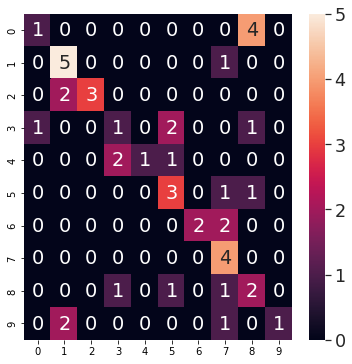

In [60]:
#Print confusion matrix
cm = confusion_matrix(df_test['label'], test_pred_svm)
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=ax)

**Random image to Test**

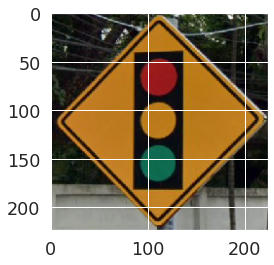

In [81]:
#Check results on a few random images
n=random.randint(0, test_array.shape[0]-1) #Select the index of image to be loaded for testing
img = test_array[n]
plt.imshow(img)

In [82]:
#Extract features and reshape to right dimensions
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=feature_extractor(input_img)
input_img_features = np.expand_dims(input_img_features, axis=0)
input_img_for_RF = np.reshape(input_img_features, (input_img.shape[0], -1))
#Predict
img_pred_svm = SVM_model.predict(input_img_for_RF)
img_pred_svm = le.inverse_transform([img_pred_svm])  #Reverse the label encoder to original name
print("The prediction for this image is: ", img_pred_svm)
print("The actual label for this image is: ", encode_dict[str(y_test[n])])

  0%|          | 0/1 [00:00<?, ?it/s]

The prediction for this image is:  ['Traffic signal ahead']
The actual label for this image is:  Traffic signal ahead


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# **Random Forest**

For Random forest we can use same dataset that we preprocessing in Support Vector Machine session to continue this session. So, We can continue to modeling now.

## Modeling

In [83]:
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
RF_model.fit(x_train, y_train) #For sklearn no one hot encoding

RandomForestClassifier(n_estimators=50, random_state=42)

In [84]:
#Predict on test
test_pred_rf = RF_model.predict(x_test)

#Inverse le transform to get original label back. 
test_pred_rf = le.inverse_transform(test_pred_rf)

#Print overall accuracy
print ("Accuracy = ", metrics.accuracy_score(df_test['label'], test_pred_rf))

Accuracy =  0.6382978723404256


## Evaluation

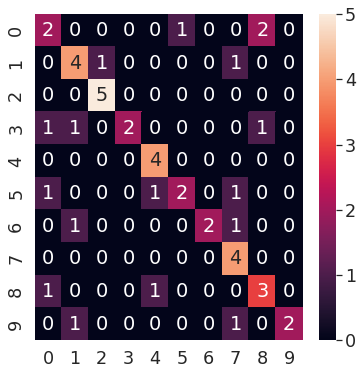

In [85]:
#Print confusion matrix
cm = confusion_matrix(df_test['label'], test_pred_rf)
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=ax)

**Random image to test**

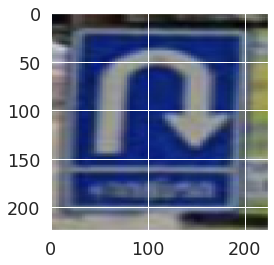

In [86]:
#Check results on a few random images
n=random.randint(0, test_array.shape[0]-1) #Select the index of image to be loaded for testing
img = test_array[n]
plt.imshow(img)

In [87]:
#Extract features and reshape to right dimensions
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=feature_extractor(input_img)
input_img_features = np.expand_dims(input_img_features, axis=0)
input_img_for_RF = np.reshape(input_img_features, (input_img.shape[0], -1))
#Predict
img_pred_rf = RF_model.predict(input_img_for_RF)
img_pred_rf = le.inverse_transform([img_pred_rf])  #Reverse the label encoder to original name
print("The prediction for this image is: ", img_pred_rf)
print("The actual label for this image is: ", encode_dict[str(y_test[n])])

  0%|          | 0/1 [00:00<?, ?it/s]

The prediction for this image is:  ['U turn']
The actual label for this image is:  U turn


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# A few more test


> We suspect about accuracy of Support Vector Machine and Random Forest. The Number of classes have effect in image classification? So, We need to test it



## 2 Group
Group A

* Speed Limit 30
* Speed Limit 80
* Crossroad
* Crosswalk
* Left Always pass

Group B

* Predestrain
* Roundabout
* School
* Traffic signal ahead
* U turn

We split it like this and test same method. Get result and compare it.

In [146]:
# Split df to each classes
df_30 = all_df.loc[all_df['label'] == label_dict['30']]
df_80 = all_df.loc[all_df['label'] == label_dict['80']]
cr_df = all_df.loc[all_df['label'] == label_dict['cr']]
cw_df = all_df.loc[all_df['label'] == label_dict['cw']]
le_df = all_df.loc[all_df['label'] == label_dict['le']]
pr_df = all_df.loc[all_df['label'] == label_dict['pr']]
ro_df = all_df.loc[all_df['label'] == label_dict['ro']]
sc_df = all_df.loc[all_df['label'] == label_dict['sc']]
tl_df = all_df.loc[all_df['label'] == label_dict['tl']]
ut_df = all_df.loc[all_df['label'] == label_dict['ut']]

# Group A
d3_tr, d3_te = train_test_split(df_30, test_size = .1)
d8_tr, d8_te = train_test_split(df_80, test_size = .1)
cr_tr, cr_te = train_test_split(cr_df, test_size = .1)
cw_tr, cw_te = train_test_split(cw_df, test_size = .1)
le_tr, le_te = train_test_split(le_df, test_size = .1)

# Group B
pr_tr, pr_te = train_test_split(pr_df, test_size = .1)
ro_tr, ro_te = train_test_split(ro_df, test_size = .1)
sc_tr, sc_te = train_test_split(sc_df, test_size = .1)
tl_tr, tl_te = train_test_split(tl_df, test_size = .1)
ut_tr, ut_te = train_test_split(ut_df, test_size = .1)

# train test split group 1
df_train_A = pd.concat([d3_tr, d8_tr, cr_tr, cw_tr, le_tr])
print(df_train_A.shape)

df_test_A = pd.concat([d3_te, d8_te, cr_te, cw_te, le_te])
print(df_test_A.shape)

# train test split group 2
df_train_B = pd.concat([pr_tr, ro_tr, sc_tr, tl_tr, ut_tr])
print(df_train_B.shape)

df_test_B = pd.concat([pr_te, ro_te, sc_te, tl_te, ut_te])
print(df_test_B.shape)

(208, 2)
(24, 2)
(207, 2)
(23, 2)


### Group A

#### Preprocessing

In [147]:
#create preset of image generator
train_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range = [0.4,1.5],
    zoom_range = 0.3,
    fill_mode = 'reflect'
)

test_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

X_COL = 'filepath'
Y_COL = 'label'
MODE = 'rgb'
BATCH_SIZE = 1

#load data by flow_from_dataframe
train_ds = train_generator.flow_from_dataframe(
    dataframe = df_train_A,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = (224, 224),
    color_mode = MODE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

test_ds = test_generator.flow_from_dataframe(
    dataframe = df_test_A,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = (224, 224),
    color_mode = MODE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

##################################################

#convert image to array
train_list = []
batch_index_train = 0

while batch_index_train <= train_ds.batch_index:
    data = train_ds.next()
    train_list.append(data[0])
    batch_index_train = batch_index_train + 1

# now, data_array is the numeric data of whole images
train_array = np.asarray(train_list)

print(train_array.shape)

test_list = []
batch_index_test = 0

while batch_index_test <= test_ds.batch_index:
    data = test_ds.next()
    test_list.append(data[0])
    batch_index_test = batch_index_test + 1

# now, data_array is the numeric data of whole images
test_array = np.asarray(test_list)

print(test_array.shape)

#################################################

#reduce dimension
train_array = np.squeeze(train_array, axis=1)
print(train_array.shape)

test_array = np.squeeze(test_array, axis=1)
print(test_array.shape)

#################################################

#convert label into integer
le = preprocessing.LabelEncoder()
le.fit(df_train_A['label'])
y_train = le.transform(df_train_A['label'])
le.fit(df_test_A['label'])
y_test = le.transform(df_test_A['label'])

Found 208 validated image filenames belonging to 5 classes.
Found 24 validated image filenames belonging to 5 classes.
(208, 1, 224, 224, 3)
(24, 1, 224, 224, 3)
(208, 224, 224, 3)
(24, 224, 224, 3)


#### Features Extraction

In [148]:
#Extract features from training images
image_features = feature_extractor(train_array)
print(image_features.shape)

test_features = feature_extractor(test_array)
print(test_features.shape)

############################################

#Reshape to a vector for RF and SVM
n_features = image_features.shape[1]
image_features = np.expand_dims(image_features, axis=0)
x_train = np.reshape(image_features, (train_array.shape[0], -1))  #Reshape to #images, features
print(x_train.shape)

#Reshape from test data, just like training data
test_features = np.expand_dims(test_features, axis=0)
x_test = np.reshape(test_features, (test_array.shape[0], -1))   #Reshape to #images, features
print(x_test.shape)

  0%|          | 0/208 [00:00<?, ?it/s]

(31309824, 6)


  0%|          | 0/24 [00:00<?, ?it/s]

(3612672, 6)
(208, 903168)
(24, 903168)


#### Modeling & Evaluation

**Support Vector Machine**

Accuracy = 0.625


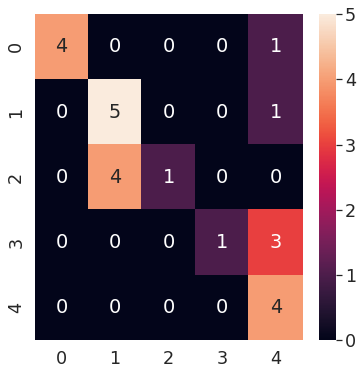

In [149]:
from sklearn import svm
SVM_model = svm.SVC(decision_function_shape='ovo')  #For multiclass classification
SVM_model.fit(x_train, y_train)

#Predict on test
test_pred_svm = SVM_model.predict(x_test)

#Inverse le transform to get original label back. 
test_pred_svm = le.inverse_transform(test_pred_svm)

#Print overall accuracy
SVM_A = str("Accuracy = " + str(metrics.accuracy_score(df_test_A['label'], test_pred_svm)))
print(SVM_A)

#Print confusion matrix
cm_SVM_A = confusion_matrix(df_test_A['label'], test_pred_svm)
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm_SVM_A, annot=True, ax=ax)

**Random Forest**

Accuracy = 0.8333333333333334


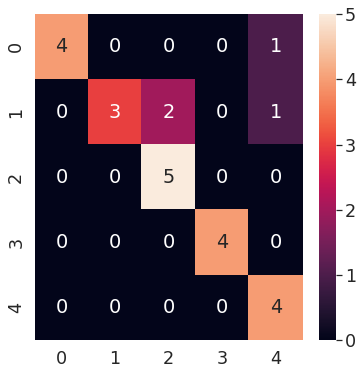

In [150]:
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
RF_model.fit(x_train, y_train) #For sklearn no one hot encoding

#Predict on test
test_pred_rf = RF_model.predict(x_test)

#Inverse le transform to get original label back. 
test_pred_rf = le.inverse_transform(test_pred_rf)

#Print overall accuracy
RF_A = str("Accuracy = " + str(metrics.accuracy_score(df_test_A['label'], test_pred_rf)))
print(RF_A)

#Print confusion matrix
cm_RF_A = confusion_matrix(df_test_A['label'], test_pred_rf)
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm_RF_A, annot=True, ax=ax)

### Group B

####Preprocessing

In [151]:
#create preset of image generator
train_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range = [0.4,1.5],
    zoom_range = 0.3,
    fill_mode = 'reflect'
)

test_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

X_COL = 'filepath'
Y_COL = 'label'
MODE = 'rgb'
BATCH_SIZE = 1

#load data by flow_from_dataframe
train_ds = train_generator.flow_from_dataframe(
    dataframe = df_train_B,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = (224, 224),
    color_mode = MODE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

test_ds = test_generator.flow_from_dataframe(
    dataframe = df_test_B,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = (224, 224),
    color_mode = MODE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

##################################################

#convert image to array
train_list = []
batch_index_train = 0

while batch_index_train <= train_ds.batch_index:
    data = train_ds.next()
    train_list.append(data[0])
    batch_index_train = batch_index_train + 1

# now, data_array is the numeric data of whole images
train_array = np.asarray(train_list)

print(train_array.shape)

test_list = []
batch_index_test = 0

while batch_index_test <= test_ds.batch_index:
    data = test_ds.next()
    test_list.append(data[0])
    batch_index_test = batch_index_test + 1

# now, data_array is the numeric data of whole images
test_array = np.asarray(test_list)

print(test_array.shape)

#################################################

#reduce dimension
train_array = np.squeeze(train_array, axis=1)
print(train_array.shape)

test_array = np.squeeze(test_array, axis=1)
print(test_array.shape)

#################################################

#convert label into integer
le = preprocessing.LabelEncoder()
le.fit(df_train_B['label'])
y_train = le.transform(df_train_B['label'])
le.fit(df_test_B['label'])
y_test = le.transform(df_test_B['label'])

Found 207 validated image filenames belonging to 5 classes.
Found 23 validated image filenames belonging to 5 classes.
(207, 1, 224, 224, 3)
(23, 1, 224, 224, 3)
(207, 224, 224, 3)
(23, 224, 224, 3)


####Features Extraction

In [152]:
#Extract features from training images
image_features = feature_extractor(train_array)
print(image_features.shape)

test_features = feature_extractor(test_array)
print(test_features.shape)

############################################

#Reshape to a vector for RF and SVM
n_features = image_features.shape[1]
image_features = np.expand_dims(image_features, axis=0)
x_train = np.reshape(image_features, (train_array.shape[0], -1))  #Reshape to #images, features
print(x_train.shape)

#Reshape from test data, just like training data
test_features = np.expand_dims(test_features, axis=0)
x_test = np.reshape(test_features, (test_array.shape[0], -1))   #Reshape to #images, features
print(x_test.shape)

  0%|          | 0/207 [00:00<?, ?it/s]

(31159296, 6)


  0%|          | 0/23 [00:00<?, ?it/s]

(3462144, 6)
(207, 903168)
(23, 903168)


####Modeling & Evaluation

**Support Vector Machine**

Accuracy = 0.34782608695652173


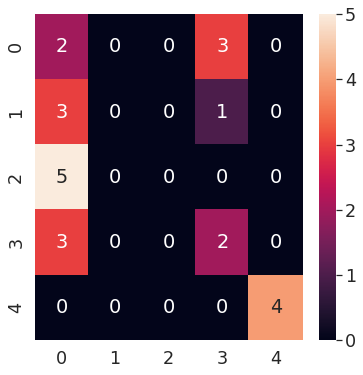

In [153]:
from sklearn import svm
SVM_model = svm.SVC(decision_function_shape='ovo')  #For multiclass classification
SVM_model.fit(x_train, y_train)

#Predict on test
test_pred_svm = SVM_model.predict(x_test)

#Inverse le transform to get original label back. 
test_pred_svm = le.inverse_transform(test_pred_svm)

#Print overall accuracy
SVM_B = str("Accuracy = " + str(metrics.accuracy_score(df_test_B['label'], test_pred_svm)))
print(SVM_B)

#Print confusion matrix
cm_SVM_B = confusion_matrix(df_test_B['label'], test_pred_svm)
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm_SVM_B, annot=True, ax=ax)

**Random Forest**

Accuracy = 0.4782608695652174


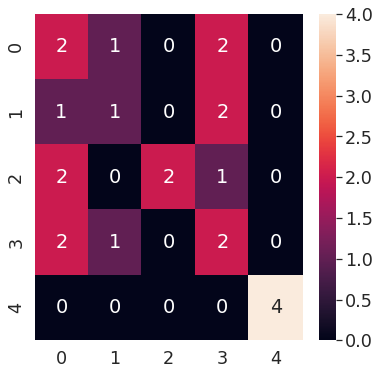

In [154]:
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
RF_model.fit(x_train, y_train) #For sklearn no one hot encoding

#Predict on test
test_pred_rf = RF_model.predict(x_test)

#Inverse le transform to get original label back. 
test_pred_rf = le.inverse_transform(test_pred_rf)

#Print overall accuracy
RF_B = str("Accuracy = "+ str(metrics.accuracy_score(df_test_B['label'], test_pred_rf)))
print(RF_B)

#Print confusion matrix
cm_RF_B = confusion_matrix(df_test_B['label'], test_pred_rf)
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm_RF_B, annot=True, ax=ax)

### Conclusion

In [155]:
# initialize list of lists
data = [['SVM A', float(SVM_A[11:])], ['RF_A', float(RF_A[11:])], ['SVM_B', float(SVM_B[11:])], ['RF_B', float(RF_B[11:])]]
 
# Create the pandas DataFrame
ac_2 = pd.DataFrame(data, columns = ['Name', 'Accuracy'])
ac_2

,Name,Accuracy
0,SVM A,0.625000
1,RF_A,0.833333
2,SVM_B,0.347826
3,RF_B,0.478261


[Text(0.5, 1.0, 'SVM in B')]

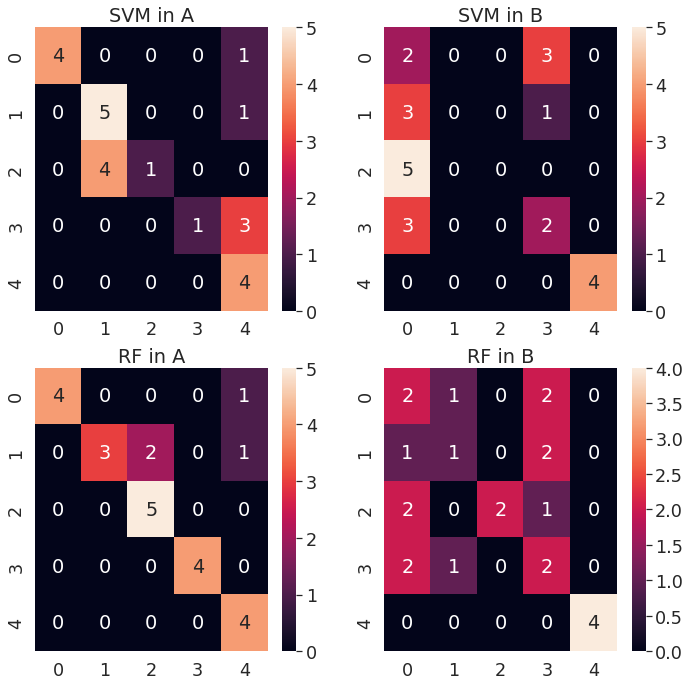

In [156]:
plt.figure(figsize=(24,24))
font_scale=1
ax1 = plt.subplot(4,4,5)
sns.heatmap(cm_RF_A, annot=True, ax=ax1).set(title='RF in A')
ax2 = plt.subplot(4,4,6)
sns.heatmap(cm_RF_B, annot=True, ax=ax2).set(title='RF in B')
ax3 = plt.subplot(4,4,1)
sns.heatmap(cm_SVM_A, annot=True, ax=ax3).set(title='SVM in A')
ax4 = plt.subplot(4,4,2)
sns.heatmap(cm_SVM_B, annot=True, ax=ax4).set(title='SVM in B')

[(0.0, 1.0)]

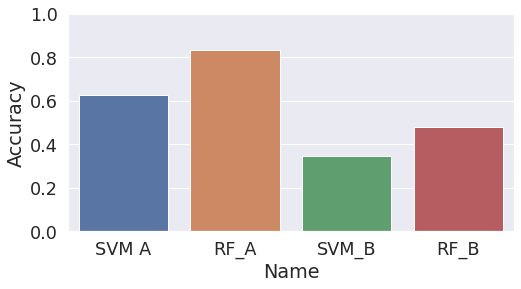

In [157]:
plt.figure(figsize=(8,4))
font_scale=1
sns.barplot(x="Name", y="Accuracy", data=ac_2).set(ylim=(0, 1))

## 5 Group
Group A

* Speed Limit 30
* Speed Limit 80

Group B

* Predestrain
* School

Group C

* Roundabout
* Crosswalk

Group D

* Crossroad
* Traffic signal ahead

Group E

* Left Always pass
* U turn

We split it like this and test same method. Get result and compare it.

In [102]:
# Split df to each classes
df_30 = all_df.loc[all_df['label'] == label_dict['30']]
df_80 = all_df.loc[all_df['label'] == label_dict['80']]
cr_df = all_df.loc[all_df['label'] == label_dict['cr']]
cw_df = all_df.loc[all_df['label'] == label_dict['cw']]
le_df = all_df.loc[all_df['label'] == label_dict['le']]
pr_df = all_df.loc[all_df['label'] == label_dict['pr']]
ro_df = all_df.loc[all_df['label'] == label_dict['ro']]
sc_df = all_df.loc[all_df['label'] == label_dict['sc']]
tl_df = all_df.loc[all_df['label'] == label_dict['tl']]
ut_df = all_df.loc[all_df['label'] == label_dict['ut']]

# Group A
d3_tr, d3_te = train_test_split(df_30, test_size = .1)
d8_tr, d8_te = train_test_split(df_80, test_size = .1)

# Group B
pr_tr, pr_te = train_test_split(pr_df, test_size = .1)
sc_tr, sc_te = train_test_split(sc_df, test_size = .1)

# Group C
cw_tr, cw_te = train_test_split(cw_df, test_size = .1)
le_tr, le_te = train_test_split(le_df, test_size = .1)

# Group D
cr_tr, cr_te = train_test_split(cr_df, test_size = .1)
tl_tr, tl_te = train_test_split(tl_df, test_size = .1)

# Group E
ro_tr, ro_te = train_test_split(ro_df, test_size = .1)
ut_tr, ut_te = train_test_split(ut_df, test_size = .1)

# train test split group A
df_train_A = pd.concat([d3_tr, d8_tr])
print(df_train_A.shape)

df_test_A = pd.concat([d3_te, d8_te])
print(df_test_A.shape)

print('-------------------')

# train test split group B
df_train_B = pd.concat([pr_tr, sc_tr])
print(df_train_B.shape)

df_test_B = pd.concat([pr_te, sc_te,])
print(df_test_B.shape)

print('-------------------')

# train test split group C
df_train_C = pd.concat([cw_tr, le_tr])
print(df_train_C.shape)

df_test_C = pd.concat([cw_te, le_te])
print(df_test_C.shape)

print('-------------------')

# train test split group D
df_train_D = pd.concat([cr_tr, tl_tr])
print(df_train_D.shape)

df_test_D = pd.concat([cr_te, tl_te])
print(df_test_D.shape)

print('-------------------')

# train test split group E
df_train_E = pd.concat([ro_tr, ut_tr])
print(df_train_E.shape)

df_test_E = pd.concat([ro_te, ut_te])
print(df_test_E.shape)

print('-------------------')

(72, 2)
(8, 2)
-------------------
(90, 2)
(10, 2)
-------------------
(91, 2)
(11, 2)
-------------------
(90, 2)
(10, 2)
-------------------
(72, 2)
(8, 2)
-------------------


### Group A

#### Preprocessing

In [136]:
#create preset of image generator
train_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range = [0.4,1.5],
    zoom_range = 0.3,
    fill_mode = 'reflect'
)

test_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

X_COL = 'filepath'
Y_COL = 'label'
MODE = 'rgb'
BATCH_SIZE = 1

#load data by flow_from_dataframe
train_ds = train_generator.flow_from_dataframe(
    dataframe = df_train_A,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = (224, 224),
    color_mode = MODE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

test_ds = test_generator.flow_from_dataframe(
    dataframe = df_test_A,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = (224, 224),
    color_mode = MODE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

##################################################

#convert image to array
train_list = []
batch_index_train = 0

while batch_index_train <= train_ds.batch_index:
    data = train_ds.next()
    train_list.append(data[0])
    batch_index_train = batch_index_train + 1

# now, data_array is the numeric data of whole images
train_array = np.asarray(train_list)

print(train_array.shape)

test_list = []
batch_index_test = 0

while batch_index_test <= test_ds.batch_index:
    data = test_ds.next()
    test_list.append(data[0])
    batch_index_test = batch_index_test + 1

# now, data_array is the numeric data of whole images
test_array = np.asarray(test_list)

print(test_array.shape)

#################################################

#reduce dimension
train_array = np.squeeze(train_array, axis=1)
print(train_array.shape)

test_array = np.squeeze(test_array, axis=1)
print(test_array.shape)

#################################################

#convert label into integer
le = preprocessing.LabelEncoder()
le.fit(df_train_A['label'])
y_train = le.transform(df_train_A['label'])
le.fit(df_test_A['label'])
y_test = le.transform(df_test_A['label'])

Found 72 validated image filenames belonging to 2 classes.
Found 8 validated image filenames belonging to 2 classes.
(72, 1, 224, 224, 3)
(8, 1, 224, 224, 3)
(72, 224, 224, 3)
(8, 224, 224, 3)


#### Features Extraction

In [137]:
#Extract features from training images
image_features = feature_extractor(train_array)
print(image_features.shape)

test_features = feature_extractor(test_array)
print(test_features.shape)

############################################

#Reshape to a vector for RF and SVM
n_features = image_features.shape[1]
image_features = np.expand_dims(image_features, axis=0)
x_train = np.reshape(image_features, (train_array.shape[0], -1))  #Reshape to #images, features
print(x_train.shape)

#Reshape from test data, just like training data
test_features = np.expand_dims(test_features, axis=0)
x_test = np.reshape(test_features, (test_array.shape[0], -1))   #Reshape to #images, features
print(x_test.shape)

  0%|          | 0/72 [00:00<?, ?it/s]

(10838016, 6)


  0%|          | 0/8 [00:00<?, ?it/s]

(1204224, 6)
(72, 903168)
(8, 903168)


#### Modeling & Evaluation

**Support Vector Machine**

Accuracy = 0.5


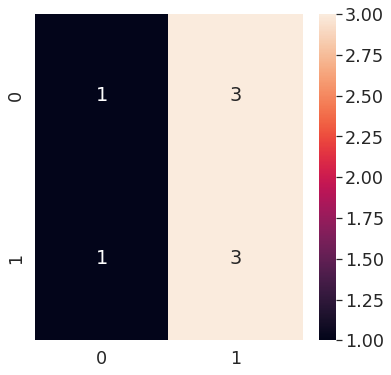

In [138]:
from sklearn import svm
SVM_model = svm.SVC(decision_function_shape='ovo')  #For multiclass classification
SVM_model.fit(x_train, y_train)

#Predict on test
test_pred_svm = SVM_model.predict(x_test)

#Inverse le transform to get original label back. 
test_pred_svm = le.inverse_transform(test_pred_svm)

#Print overall accuracy
SVM_A = str("Accuracy = " + str(metrics.accuracy_score(df_test_A['label'], test_pred_svm)))
print(SVM_A)

#Print confusion matrix
cm_SVM_A = confusion_matrix(df_test_A['label'], test_pred_svm)
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm_SVM_A, annot=True, ax=ax)

**Random Forest**

Accuracy = 0.75


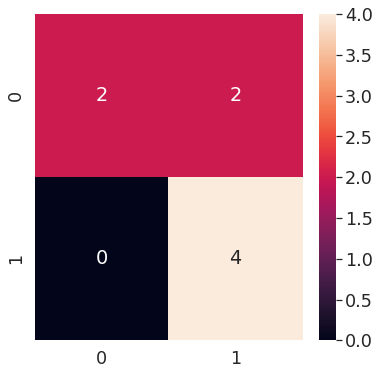

In [139]:
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
RF_model.fit(x_train, y_train) #For sklearn no one hot encoding

#Predict on test
test_pred_rf = RF_model.predict(x_test)

#Inverse le transform to get original label back. 
test_pred_rf = le.inverse_transform(test_pred_rf)

#Print overall accuracy
RF_A = str("Accuracy = " + str(metrics.accuracy_score(df_test_A['label'], test_pred_rf)))
print(RF_A)

#Print confusion matrix
cm_RF_A = confusion_matrix(df_test_A['label'], test_pred_rf)
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm_RF_A, annot=True, ax=ax)

### Group B

####Preprocessing

In [129]:
#create preset of image generator
train_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range = [0.4,1.5],
    zoom_range = 0.3,
    fill_mode = 'reflect'
)

test_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

X_COL = 'filepath'
Y_COL = 'label'
MODE = 'rgb'
BATCH_SIZE = 1

#load data by flow_from_dataframe
train_ds = train_generator.flow_from_dataframe(
    dataframe = df_train_B,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = (224, 224),
    color_mode = MODE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

test_ds = test_generator.flow_from_dataframe(
    dataframe = df_test_B,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = (224, 224),
    color_mode = MODE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

##################################################

#convert image to array
train_list = []
batch_index_train = 0

while batch_index_train <= train_ds.batch_index:
    data = train_ds.next()
    train_list.append(data[0])
    batch_index_train = batch_index_train + 1

# now, data_array is the numeric data of whole images
train_array = np.asarray(train_list)

print(train_array.shape)

test_list = []
batch_index_test = 0

while batch_index_test <= test_ds.batch_index:
    data = test_ds.next()
    test_list.append(data[0])
    batch_index_test = batch_index_test + 1

# now, data_array is the numeric data of whole images
test_array = np.asarray(test_list)

print(test_array.shape)

#################################################

#reduce dimension
train_array = np.squeeze(train_array, axis=1)
print(train_array.shape)

test_array = np.squeeze(test_array, axis=1)
print(test_array.shape)

#################################################

#convert label into integer
le = preprocessing.LabelEncoder()
le.fit(df_train_B['label'])
y_train = le.transform(df_train_B['label'])
le.fit(df_test_B['label'])
y_test = le.transform(df_test_B['label'])

Found 90 validated image filenames belonging to 2 classes.
Found 10 validated image filenames belonging to 2 classes.
(90, 1, 224, 224, 3)
(10, 1, 224, 224, 3)
(90, 224, 224, 3)
(10, 224, 224, 3)


####Features Extraction

In [130]:
#Extract features from training images
image_features = feature_extractor(train_array)
print(image_features.shape)

test_features = feature_extractor(test_array)
print(test_features.shape)

############################################

#Reshape to a vector for RF and SVM
n_features = image_features.shape[1]
image_features = np.expand_dims(image_features, axis=0)
x_train = np.reshape(image_features, (train_array.shape[0], -1))  #Reshape to #images, features
print(x_train.shape)

#Reshape from test data, just like training data
test_features = np.expand_dims(test_features, axis=0)
x_test = np.reshape(test_features, (test_array.shape[0], -1))   #Reshape to #images, features
print(x_test.shape)

  0%|          | 0/90 [00:00<?, ?it/s]

(13547520, 6)


  0%|          | 0/10 [00:00<?, ?it/s]

(1505280, 6)
(90, 903168)
(10, 903168)


####Modeling & Evaluation

**Support Vector Machine**

Accuracy = 0.6


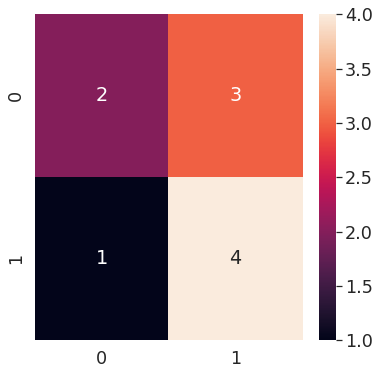

In [131]:
from sklearn import svm
SVM_model = svm.SVC(decision_function_shape='ovo')  #For multiclass classification
SVM_model.fit(x_train, y_train)

#Predict on test
test_pred_svm = SVM_model.predict(x_test)

#Inverse le transform to get original label back. 
test_pred_svm = le.inverse_transform(test_pred_svm)

#Print overall accuracy
SVM_B = str("Accuracy = " + str(metrics.accuracy_score(df_test_B['label'], test_pred_svm)))
print(SVM_B)

#Print confusion matrix
cm_SVM_B = confusion_matrix(df_test_B['label'], test_pred_svm)
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm_SVM_B, annot=True, ax=ax)

**Random Forest**

Accuracy = 0.8


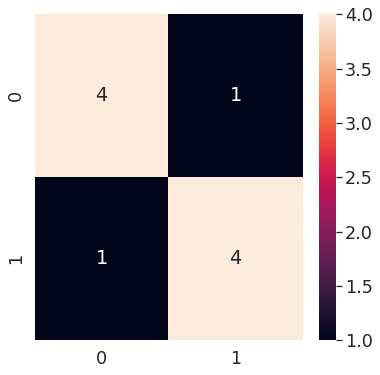

In [132]:
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
RF_model.fit(x_train, y_train) #For sklearn no one hot encoding

#Predict on test
test_pred_rf = RF_model.predict(x_test)

#Inverse le transform to get original label back. 
test_pred_rf = le.inverse_transform(test_pred_rf)

#Print overall accuracy
RF_B = str("Accuracy = "+ str(metrics.accuracy_score(df_test_B['label'], test_pred_rf)))
print(RF_B)

#Print confusion matrix
cm_RF_B = confusion_matrix(df_test_B['label'], test_pred_rf)
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm_RF_B, annot=True, ax=ax)

### Group C

####Preprocessing

In [111]:
#create preset of image generator
train_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range = [0.4,1.5],
    zoom_range = 0.3,
    fill_mode = 'reflect'
)

test_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

X_COL = 'filepath'
Y_COL = 'label'
MODE = 'rgb'
BATCH_SIZE = 1

#load data by flow_from_dataframe
train_ds = train_generator.flow_from_dataframe(
    dataframe = df_train_C,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = (224, 224),
    color_mode = MODE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

test_ds = test_generator.flow_from_dataframe(
    dataframe = df_test_C,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = (224, 224),
    color_mode = MODE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

##################################################

#convert image to array
train_list = []
batch_index_train = 0

while batch_index_train <= train_ds.batch_index:
    data = train_ds.next()
    train_list.append(data[0])
    batch_index_train = batch_index_train + 1

# now, data_array is the numeric data of whole images
train_array = np.asarray(train_list)

print(train_array.shape)

test_list = []
batch_index_test = 0

while batch_index_test <= test_ds.batch_index:
    data = test_ds.next()
    test_list.append(data[0])
    batch_index_test = batch_index_test + 1

# now, data_array is the numeric data of whole images
test_array = np.asarray(test_list)

print(test_array.shape)

#################################################

#reduce dimension
train_array = np.squeeze(train_array, axis=1)
print(train_array.shape)

test_array = np.squeeze(test_array, axis=1)
print(test_array.shape)

#################################################

#convert label into integer
le = preprocessing.LabelEncoder()
le.fit(df_train_C['label'])
y_train = le.transform(df_train_C['label'])
le.fit(df_test_C['label'])
y_test = le.transform(df_test_C['label'])

Found 91 validated image filenames belonging to 2 classes.
Found 11 validated image filenames belonging to 2 classes.
(91, 1, 224, 224, 3)
(11, 1, 224, 224, 3)
(91, 224, 224, 3)
(11, 224, 224, 3)


####Features Extraction

In [112]:
#Extract features from training images
image_features = feature_extractor(train_array)
print(image_features.shape)

test_features = feature_extractor(test_array)
print(test_features.shape)

############################################

#Reshape to a vector for RF and SVM
n_features = image_features.shape[1]
image_features = np.expand_dims(image_features, axis=0)
x_train = np.reshape(image_features, (train_array.shape[0], -1))  #Reshape to #images, features
print(x_train.shape)

#Reshape from test data, just like training data
test_features = np.expand_dims(test_features, axis=0)
x_test = np.reshape(test_features, (test_array.shape[0], -1))   #Reshape to #images, features
print(x_test.shape)

  0%|          | 0/91 [00:00<?, ?it/s]

(13698048, 6)


  0%|          | 0/11 [00:00<?, ?it/s]

(1655808, 6)
(91, 903168)
(11, 903168)


####Modeling & Evaluation

**Support Vector Machine**

Accuracy = 0.6363636363636364


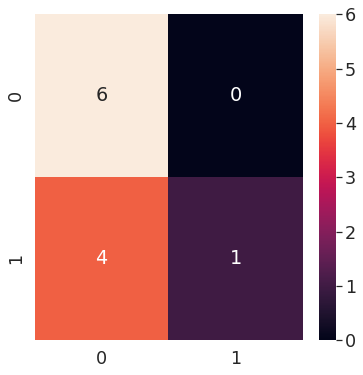

In [113]:
from sklearn import svm
SVM_model = svm.SVC(decision_function_shape='ovo')  #For multiclass classification
SVM_model.fit(x_train, y_train)

#Predict on test
test_pred_svm = SVM_model.predict(x_test)

#Inverse le transform to get original label back. 
test_pred_svm = le.inverse_transform(test_pred_svm)

#Print overall accuracy
SVM_C = str("Accuracy = " + str(metrics.accuracy_score(df_test_C['label'], test_pred_svm)))
print(SVM_C)

#Print confusion matrix
cm_SVM_C = confusion_matrix(df_test_C['label'], test_pred_svm)
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm_SVM_C, annot=True, ax=ax)

**Random Forest**

Accuracy = 0.8181818181818182


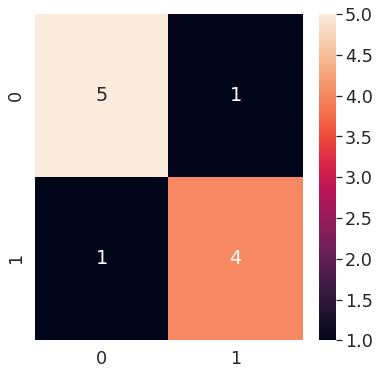

In [114]:
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
RF_model.fit(x_train, y_train) #For sklearn no one hot encoding

#Predict on test
test_pred_rf = RF_model.predict(x_test)

#Inverse le transform to get original label back. 
test_pred_rf = le.inverse_transform(test_pred_rf)

#Print overall accuracy
RF_C = str("Accuracy = "+ str(metrics.accuracy_score(df_test_C['label'], test_pred_rf)))
print(RF_C)

#Print confusion matrix
cm_RF_C = confusion_matrix(df_test_C['label'], test_pred_rf)
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm_RF_C, annot=True, ax=ax)

### Group D

####Preprocessing

In [115]:
#create preset of image generator
train_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range = [0.4,1.5],
    zoom_range = 0.3,
    fill_mode = 'reflect'
)

test_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

X_COL = 'filepath'
Y_COL = 'label'
MODE = 'rgb'
BATCH_SIZE = 1

#load data by flow_from_dataframe
train_ds = train_generator.flow_from_dataframe(
    dataframe = df_train_D,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = (224, 224),
    color_mode = MODE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

test_ds = test_generator.flow_from_dataframe(
    dataframe = df_test_D,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = (224, 224),
    color_mode = MODE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

##################################################

#convert image to array
train_list = []
batch_index_train = 0

while batch_index_train <= train_ds.batch_index:
    data = train_ds.next()
    train_list.append(data[0])
    batch_index_train = batch_index_train + 1

# now, data_array is the numeric data of whole images
train_array = np.asarray(train_list)

print(train_array.shape)

test_list = []
batch_index_test = 0

while batch_index_test <= test_ds.batch_index:
    data = test_ds.next()
    test_list.append(data[0])
    batch_index_test = batch_index_test + 1

# now, data_array is the numeric data of whole images
test_array = np.asarray(test_list)

print(test_array.shape)

#################################################

#reduce dimension
train_array = np.squeeze(train_array, axis=1)
print(train_array.shape)

test_array = np.squeeze(test_array, axis=1)
print(test_array.shape)

#################################################

#convert label into integer
le = preprocessing.LabelEncoder()
le.fit(df_train_D['label'])
y_train = le.transform(df_train_D['label'])
le.fit(df_test_D['label'])
y_test = le.transform(df_test_D['label'])

Found 90 validated image filenames belonging to 2 classes.
Found 10 validated image filenames belonging to 2 classes.
(90, 1, 224, 224, 3)
(10, 1, 224, 224, 3)
(90, 224, 224, 3)
(10, 224, 224, 3)


####Features Extraction

In [116]:
#Extract features from training images
image_features = feature_extractor(train_array)
print(image_features.shape)

test_features = feature_extractor(test_array)
print(test_features.shape)

############################################

#Reshape to a vector for RF and SVM
n_features = image_features.shape[1]
image_features = np.expand_dims(image_features, axis=0)
x_train = np.reshape(image_features, (train_array.shape[0], -1))  #Reshape to #images, features
print(x_train.shape)

#Reshape from test data, just like training data
test_features = np.expand_dims(test_features, axis=0)
x_test = np.reshape(test_features, (test_array.shape[0], -1))   #Reshape to #images, features
print(x_test.shape)

  0%|          | 0/90 [00:00<?, ?it/s]

(13547520, 6)


  0%|          | 0/10 [00:00<?, ?it/s]

(1505280, 6)
(90, 903168)
(10, 903168)


####Modeling & Evaluation

**Support Vector Machine**

Accuracy = 0.7


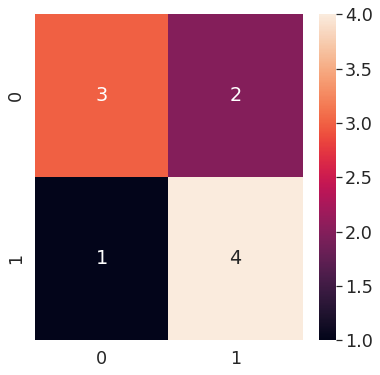

In [117]:
from sklearn import svm
SVM_model = svm.SVC(decision_function_shape='ovo')  #For multiclass classification
SVM_model.fit(x_train, y_train)

#Predict on test
test_pred_svm = SVM_model.predict(x_test)

#Inverse le transform to get original label back. 
test_pred_svm = le.inverse_transform(test_pred_svm)

#Print overall accuracy
SVM_D = str("Accuracy = " + str(metrics.accuracy_score(df_test_D['label'], test_pred_svm)))
print(SVM_D)

#Print confusion matrix
cm_SVM_D = confusion_matrix(df_test_D['label'], test_pred_svm)
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm_SVM_D, annot=True, ax=ax)

**Random Forest**

Accuracy = 1.0


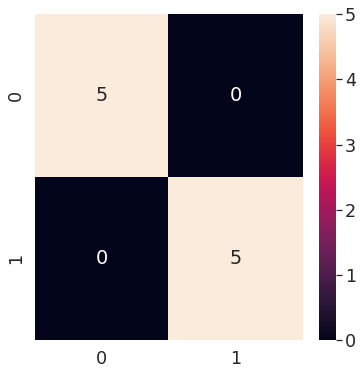

In [118]:
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
RF_model.fit(x_train, y_train) #For sklearn no one hot encoding

#Predict on test
test_pred_rf = RF_model.predict(x_test)

#Inverse le transform to get original label back. 
test_pred_rf = le.inverse_transform(test_pred_rf)

#Print overall accuracy
RF_D = str("Accuracy = "+ str(metrics.accuracy_score(df_test_D['label'], test_pred_rf)))
print(RF_D)

#Print confusion matrix
cm_RF_D = confusion_matrix(df_test_D['label'], test_pred_rf)
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm_RF_D, annot=True, ax=ax)

### Group E

####Preprocessing

In [119]:
#create preset of image generator
train_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range = [0.4,1.5],
    zoom_range = 0.3,
    fill_mode = 'reflect'
)

test_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

X_COL = 'filepath'
Y_COL = 'label'
MODE = 'rgb'
BATCH_SIZE = 1

#load data by flow_from_dataframe
train_ds = train_generator.flow_from_dataframe(
    dataframe = df_train_E,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = (224, 224),
    color_mode = MODE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

test_ds = test_generator.flow_from_dataframe(
    dataframe = df_test_E,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = (224, 224),
    color_mode = MODE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

##################################################

#convert image to array
train_list = []
batch_index_train = 0

while batch_index_train <= train_ds.batch_index:
    data = train_ds.next()
    train_list.append(data[0])
    batch_index_train = batch_index_train + 1

# now, data_array is the numeric data of whole images
train_array = np.asarray(train_list)

print(train_array.shape)

test_list = []
batch_index_test = 0

while batch_index_test <= test_ds.batch_index:
    data = test_ds.next()
    test_list.append(data[0])
    batch_index_test = batch_index_test + 1

# now, data_array is the numeric data of whole images
test_array = np.asarray(test_list)

print(test_array.shape)

#################################################

#reduce dimension
train_array = np.squeeze(train_array, axis=1)
print(train_array.shape)

test_array = np.squeeze(test_array, axis=1)
print(test_array.shape)

#################################################

#convert label into integer
le = preprocessing.LabelEncoder()
le.fit(df_train_E['label'])
y_train = le.transform(df_train_E['label'])
le.fit(df_test_E['label'])
y_test = le.transform(df_test_E['label'])

Found 72 validated image filenames belonging to 2 classes.
Found 8 validated image filenames belonging to 2 classes.
(72, 1, 224, 224, 3)
(8, 1, 224, 224, 3)
(72, 224, 224, 3)
(8, 224, 224, 3)


####Features Extraction

In [120]:
#Extract features from training images
image_features = feature_extractor(train_array)
print(image_features.shape)

test_features = feature_extractor(test_array)
print(test_features.shape)

############################################

#Reshape to a vector for RF and SVM
n_features = image_features.shape[1]
image_features = np.expand_dims(image_features, axis=0)
x_train = np.reshape(image_features, (train_array.shape[0], -1))  #Reshape to #images, features
print(x_train.shape)

#Reshape from test data, just like training data
test_features = np.expand_dims(test_features, axis=0)
x_test = np.reshape(test_features, (test_array.shape[0], -1))   #Reshape to #images, features
print(x_test.shape)

  0%|          | 0/72 [00:00<?, ?it/s]

(10838016, 6)


  0%|          | 0/8 [00:00<?, ?it/s]

(1204224, 6)
(72, 903168)
(8, 903168)


####Modeling & Evaluation

**Support Vector Machine**

Accuracy = 1.0


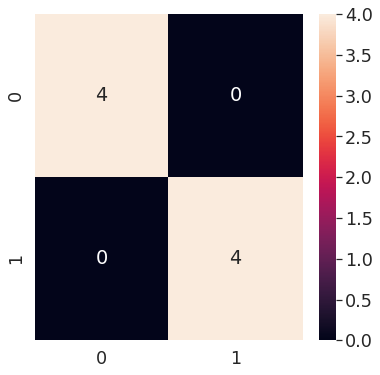

In [121]:
from sklearn import svm
SVM_model = svm.SVC(decision_function_shape='ovo')  #For multiclass classification
SVM_model.fit(x_train, y_train)

#Predict on test
test_pred_svm = SVM_model.predict(x_test)

#Inverse le transform to get original label back. 
test_pred_svm = le.inverse_transform(test_pred_svm)

#Print overall accuracy
SVM_E = str("Accuracy = " + str(metrics.accuracy_score(df_test_E['label'], test_pred_svm)))
print(SVM_E)

#Print confusion matrix
cm_SVM_E = confusion_matrix(df_test_E['label'], test_pred_svm)
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm_SVM_E, annot=True, ax=ax)

**Random Forest**

Accuracy = 1.0


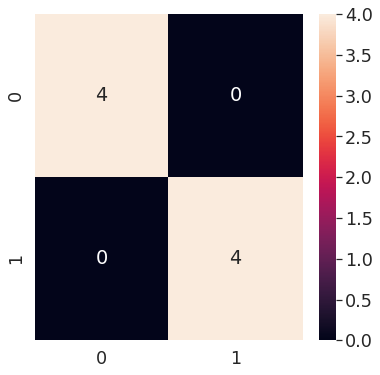

In [122]:
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
RF_model.fit(x_train, y_train) #For sklearn no one hot encoding

#Predict on test
test_pred_rf = RF_model.predict(x_test)

#Inverse le transform to get original label back. 
test_pred_rf = le.inverse_transform(test_pred_rf)

#Print overall accuracy
RF_E = str("Accuracy = "+ str(metrics.accuracy_score(df_test_E['label'], test_pred_rf)))
print(RF_E)

#Print confusion matrix
cm_RF_E = confusion_matrix(df_test_E['label'], test_pred_rf)
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm_RF_E, annot=True, ax=ax)

### Conclusion

In [143]:
# initialize list of lists
data = [['SVM A', float(SVM_A[11:])], 
        ['RF_A', float(RF_A[11:])], 
        ['SVM_B', float(SVM_B[11:])], 
        ['RF_B', float(RF_B[11:])],
        ['SVM C', float(SVM_C[11:])], 
        ['RF_C', float(RF_C[11:])], 
        ['SVM_D', float(SVM_D[11:])], 
        ['RF_D', float(RF_D[11:])],
        ['SVM_E', float(SVM_E[11:])], 
        ['RF_E', float(RF_E[11:])]
        ]
 
# Create the pandas DataFrame
ac_5 = pd.DataFrame(data, columns = ['Name', 'Accuracy'])
ac_5

,Name,Accuracy
0,SVM A,0.500000
1,RF_A,0.750000
2,SVM_B,0.600000
3,RF_B,0.800000
4,SVM C,0.636364
5,RF_C,0.818182
6,SVM_D,0.700000
7,RF_D,1.000000
8,SVM_E,1.000000
9,RF_E,1.000000


[Text(0.5, 1.0, 'SVM in E')]

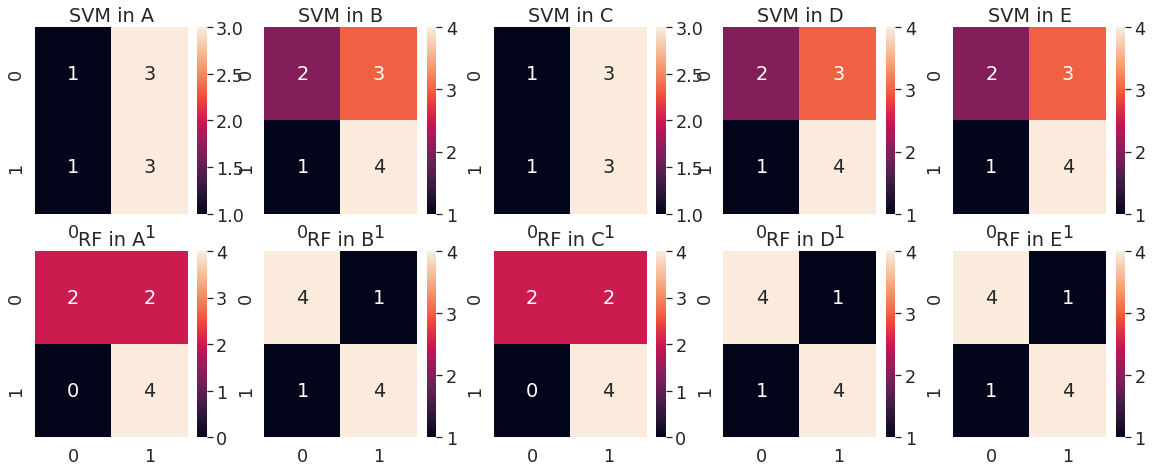

In [144]:
plt.figure(figsize=(24,24))
font_scale=1

ax1 = plt.subplot(6,6,7)
sns.heatmap(cm_RF_A, annot=True, ax=ax1).set(title='RF in A')
ax2 = plt.subplot(6,6,8)
sns.heatmap(cm_RF_B, annot=True, ax=ax2).set(title='RF in B')
ax3 = plt.subplot(6,6,9)
sns.heatmap(cm_RF_A, annot=True, ax=ax3).set(title='RF in C')
ax4 = plt.subplot(6,6,10)
sns.heatmap(cm_RF_B, annot=True, ax=ax4).set(title='RF in D')
ax5 = plt.subplot(6,6,11)
sns.heatmap(cm_RF_B, annot=True, ax=ax5).set(title='RF in E')

ax6 = plt.subplot(6,6,1)
sns.heatmap(cm_SVM_A, annot=True, ax=ax6).set(title='SVM in A')
ax7 = plt.subplot(6,6,2)
sns.heatmap(cm_SVM_B, annot=True, ax=ax7).set(title='SVM in B')
ax8 = plt.subplot(6,6,3)
sns.heatmap(cm_SVM_A, annot=True, ax=ax8).set(title='SVM in C')
ax9 = plt.subplot(6,6,4)
sns.heatmap(cm_SVM_B, annot=True, ax=ax9).set(title='SVM in D')
ax10 = plt.subplot(6,6,5)
sns.heatmap(cm_SVM_B, annot=True, ax=ax10).set(title='SVM in E')

[(0.0, 1.0)]

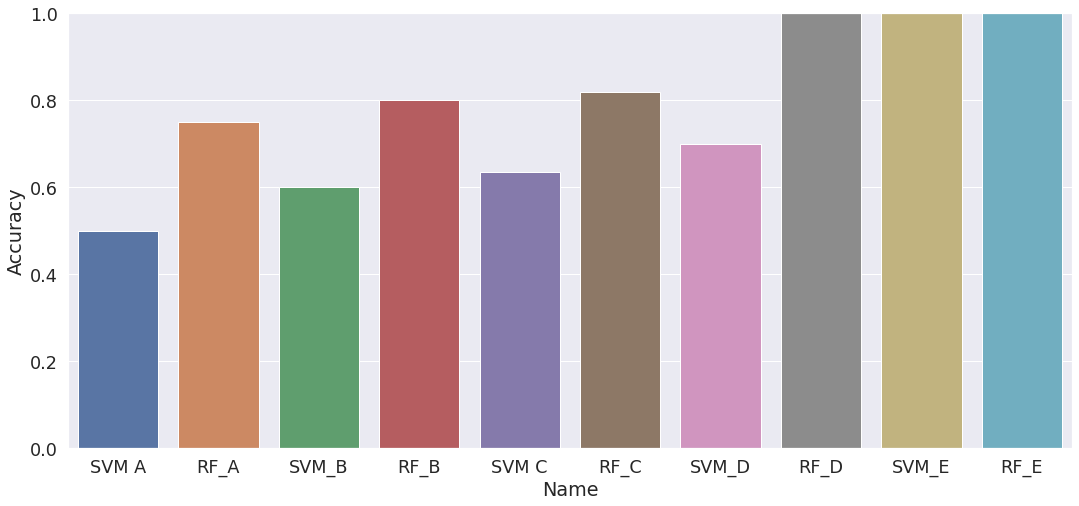

In [145]:
plt.figure(figsize=(18,8))
font_scale=1
sns.barplot(x="Name", y="Accuracy", data=ac_5).set(ylim=(0, 1))

## Summary

In [160]:
ac_2.describe()

,Accuracy
count,4.000000
mean,0.571105
std,0.208280
min,0.347826
25%,0.445652
50%,0.551630
75%,0.677083
max,0.833333


In [161]:
ac_5.describe()

,Accuracy
count,10.000000
mean,0.780455
std,0.178197
min,0.500000
25%,0.652273
50%,0.775000
75%,0.954545
max,1.000000


In [166]:
summary = ac_2.describe().join(ac_5.describe(), lsuffix='Accuracy', rsuffix='Accuracy')

In [171]:
summary.columns = ['2 Group', '5 Group']
summary

,2 Group,5 Group
count,4.000000,10.000000
mean,0.571105,0.780455
std,0.208280,0.178197
min,0.347826,0.500000
25%,0.445652,0.652273
50%,0.551630,0.775000
75%,0.677083,0.954545
max,0.833333,1.000000
